<a href="https://colab.research.google.com/github/mmadhira10/CSE216ProgAbstractionProjects/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [ ]:


import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
 
import torch
import torchvision
import torchvision.transforms as transforms
 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import timeit

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Ishan's Path: "/content/gdrive/.shortcut-targets-by-id/1dO9M2V5QqmhdjySPgoSNJEyca7qh3Mez/SPP Final Project"

Mihir's Path: "/content/gdrive/.shortcut-targets-by-id/1dO9M2V5QqmhdjySPgoSNJEyca7qh3Mez/SPP Final Project"

Ben's Path: "/content/gdrive/.shortcut-targets-by-id/1dO9M2V5QqmhdjySPgoSNJEyca7qh3Mez/SPP Final Project"

In [ ]:
import os
os.chdir("/content/gdrive/.shortcut-targets-by-id/1dO9M2V5QqmhdjySPgoSNJEyca7qh3Mez/SPP Final Project")

In [ ]:
transform_CIFAR = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),                                  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
])

transform_train_CNN = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test_CNN = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

transform_train_SPP = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test_SPP = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
            download=True, transform=transform_CIFAR)
trainset_CNN = torchvision.datasets.Caltech101(root='/Caltech101', 
            download=True, transform=transform_train_CNN)
trainset_SPP = torchvision.datasets.Caltech101(root='/Caltech101', 
            download=True, transform=transform_train_SPP)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
            shuffle=True, num_workers=2)
trainloader_CNN = torch.utils.data.DataLoader(trainset_CNN, batch_size=batch_size,
            shuffle=True, num_workers=2)
trainloader_SPP = torch.utils.data.DataLoader(trainset_SPP, batch_size=batch_size,
            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
            download=True, transform=transform_CIFAR)
testset_CNN = torchvision.datasets.Caltech101(root='/Caltech101',
            download=True, transform=transform_test_CNN)
testset_SPP = torchvision.datasets.Caltech101(root='/Caltech101',
            download=True, transform=transform_test_SPP)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
            shuffle=False, num_workers=2)
testloader_CNN = torch.utils.data.DataLoader(testset_CNN, batch_size=batch_size,
            shuffle=False, num_workers=2)
testloader_SPP = torch.utils.data.DataLoader(testset_SPP, batch_size=batch_size,
            shuffle=False, num_workers=2)

Files already downloaded and verified



Extracting /Caltech101/caltech101/101_ObjectCategories.tar.gz to /Caltech101/caltech101



Extracting /Caltech101/caltech101/101_Annotations.tar to /Caltech101/caltech101
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Print some sample images, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


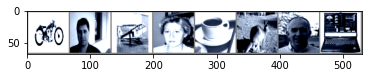

tensor([ 3,  0,  5,  1, 30, 54,  1, 57])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader_CNN)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(labels)

# **Regular CNN Model Trained on CalTech101**

This model will be trained on a dataset that we transformed to make sizes consistent to make it easier for the original CNN model to train and classify images (as a limitation of a vanilla CNN implementation). We will train and test on both the datasets of CIFAR-100 and Caltech101 to later compare with our SPP Network


Here is the CNN using the Caltech dataset to train and test on:


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 200)
        self.fc2 = nn.Linear(200, 150)
        self.fc3 = nn.Linear(150, 101)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 2704)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(5):

    print(f"Epoch #{epoch}:")
    start = timeit.default_timer()

    running_loss = 0.0
    for i, data in enumerate(trainloader_CNN, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

    end = timeit.default_timer()
    print(f"Time elapsed: {end-start}")
    print()

print('Finished Training')

Epoch #0:
[1,    50] loss: 4.258
[1,   100] loss: 3.853
[1,   150] loss: 3.769
[1,   200] loss: 3.535
[1,   250] loss: 3.434
[1,   300] loss: 3.523
[1,   350] loss: 3.227
[1,   400] loss: 3.501
[1,   450] loss: 3.410
[1,   500] loss: 3.320
[1,   550] loss: 3.079
[1,   600] loss: 3.069
[1,   650] loss: 3.065
[1,   700] loss: 3.080
[1,   750] loss: 2.985
[1,   800] loss: 2.903
[1,   850] loss: 2.947
[1,   900] loss: 2.823
[1,   950] loss: 2.832
[1,  1000] loss: 2.663
[1,  1050] loss: 2.636
Time elapsed: 37.53860288599981

Epoch #1:
[2,    50] loss: 2.357
[2,   100] loss: 2.404
[2,   150] loss: 2.253
[2,   200] loss: 2.346
[2,   250] loss: 2.394
[2,   300] loss: 2.298
[2,   350] loss: 2.560
[2,   400] loss: 2.224
[2,   450] loss: 2.281
[2,   500] loss: 2.216
[2,   550] loss: 2.271
[2,   600] loss: 2.149
[2,   650] loss: 2.427
[2,   700] loss: 2.394
[2,   750] loss: 2.452
[2,   800] loss: 2.203
[2,   850] loss: 2.214
[2,   900] loss: 2.453
[2,   950] loss: 2.266
[2,  1000] loss: 2.109
[2, 

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader_CNN:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


# **Regular CNN Trained on CIFAR-10**
(for comparison purposes)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class CNN_Cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 87)
        self.fc3 = nn.Linear(87, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = CNN_Cifar()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(5):

    print(f"Epoch #{epoch+1}:")
    start = timeit.default_timer()

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

    end = timeit.default_timer()
    print(f"Time elapsed: {end-start}")
    print()

print('Finished Training')

Epoch #1:
[1,    50] loss: 2.047
[1,   100] loss: 1.773
[1,   150] loss: 1.636
Time elapsed: 15.16753300200071

Epoch #2:
[2,    50] loss: 1.515
[2,   100] loss: 1.483
[2,   150] loss: 1.481
Time elapsed: 15.489709893001418

Epoch #3:
[3,    50] loss: 1.390
[3,   100] loss: 1.341
[3,   150] loss: 1.355
Time elapsed: 15.521315009998943

Epoch #4:
[4,    50] loss: 1.275
[4,   100] loss: 1.256
[4,   150] loss: 1.261
Time elapsed: 15.714343112998904

Epoch #5:
[5,    50] loss: 1.201
[5,   100] loss: 1.190
[5,   150] loss: 1.177
Time elapsed: 15.480834375000995

Finished Training


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
 
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


# SPP-Incorporated Model Trained on CalTech101

This is our primary implementation that we will use to demonstrate the marked improvement in image classification when different-sized images are involved. We train and test our network on the CalTech101 dataset, and show the improved difference in comparison to the regular CNN.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


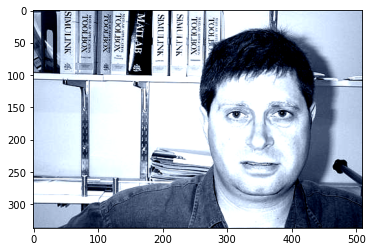

[0]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images = [trainset_SPP.__getitem__(i)[0] for i in range(1)]
labels = [trainset_SPP.__getitem__(i)[1] for i in range(1)]

imshow(torchvision.utils.make_grid(images))

print(labels)

In [ ]:
def spp_layer(self, previous_conv, num_sample, previous_conv_size, out_pool_size):

    for i in range(len(out_pool_size)):
        # get dims of spatial bins
        h_wid = int(np.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(np.ceil(previous_conv_size[1] / out_pool_size[i]))

        # if integer rounding from above leads to some cutoff edges, pad them
        h_pad = int(np.ceil( (h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2 ))
        w_pad = int(np.ceil( (w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2 ))
        # note: if the pad is too large, the bin will be blocked out; error will arise

        maxpool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(h_pad, w_pad))

        # get features from spatial bins
        x = maxpool(previous_conv)
        if(i == 0): # first pooling level
            spp = x.view(num_sample,-1)
        else: # subsequent pooling levels
            spp = torch.cat((spp,x.view(num_sample,-1)), 1)

    return spp

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SPP_CNN(nn.Module):
    def __init__(self):
        super(SPP_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(336, 250)
        self.fc2 = nn.Linear(250, 200)
        self.fc3 = nn.Linear(200, 101)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv2(x)

        x = spp_layer(self, previous_conv=x, num_sample=int(x.size(0)), \
            previous_conv_size=[int(x.size(2)),int(x.size(3))], out_pool_size=[4,2,1])
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

spp_net = SPP_CNN().cuda()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(spp_net.parameters())

In [ ]:
def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

for epoch in range(5):

    print(f"Epoch #{epoch}:")
    start = timeit.default_timer()

    running_loss = 0.0

    num_elems = trainset_SPP.__len__()
    rand_indexes = np.random.permutation(range(num_elems))

    for i, elem_index in enumerate(rand_indexes):
        inputs = trainset_SPP.__getitem__(elem_index)[0]
        labels = trainset_SPP.__getitem__(elem_index)[1]

        inputs = torch.unsqueeze(inputs, 0).cuda()
        labels = torch.Tensor([labels]).long().cuda()

        optimizer.zero_grad()

        outputs = spp_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' %
                  # (epoch + 1, i + 1, running_loss / 50))
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    end = timeit.default_timer()
    print(f"Time elapsed: {end-start}")
    print()

print('Finished Training')

Epoch #0:
[1,   200] loss: 4.471
[1,   400] loss: 4.231
[1,   600] loss: 4.329
[1,   800] loss: 4.141
[1,  1000] loss: 3.909
[1,  1200] loss: 3.954
[1,  1400] loss: 4.247
[1,  1600] loss: 3.817
[1,  1800] loss: 4.014
[1,  2000] loss: 3.743
[1,  2200] loss: 3.705
[1,  2400] loss: 3.434
[1,  2600] loss: 3.688
[1,  2800] loss: 3.644
[1,  3000] loss: 3.730
[1,  3200] loss: 3.429
[1,  3400] loss: 3.396
[1,  3600] loss: 3.226
[1,  3800] loss: 3.330
[1,  4000] loss: 3.232
[1,  4200] loss: 3.402
[1,  4400] loss: 3.195
[1,  4600] loss: 3.231
[1,  4800] loss: 2.954
[1,  5000] loss: 3.612
[1,  5200] loss: 3.209
[1,  5400] loss: 3.135
[1,  5600] loss: 3.200
[1,  5800] loss: 3.257
[1,  6000] loss: 3.111
[1,  6200] loss: 3.284
[1,  6400] loss: 2.709
[1,  6600] loss: 2.811
[1,  6800] loss: 2.868
[1,  7000] loss: 2.725
[1,  7200] loss: 3.056
[1,  7400] loss: 3.160
[1,  7600] loss: 2.959
[1,  7800] loss: 2.939
[1,  8000] loss: 2.748
[1,  8200] loss: 2.884
[1,  8400] loss: 3.102
[1,  8600] loss: 2.780
T

In [ ]:
correct = 0
total = 0

with torch.no_grad():

    for i in range(testset_SPP.__len__()):

        images = testset_SPP.__getitem__(i)[0]
        labels = testset_SPP.__getitem__(i)[1]

        images = torch.unsqueeze(images, 0).cuda()
        labels = torch.Tensor([labels]).long().cuda()

        outputs = spp_net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


# SPP-Incorporated Model Trained on CIFAR-10

In [ ]:
def spp_layer(self,previous_conv, num_sample, previous_conv_size, out_pool_size):

    for i in range(len(out_pool_size)):
         # get dims of spatial bins
        h_wid = int(np.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(np.ceil(previous_conv_size[1] / out_pool_size[i]))

        # if integer rounding from above leads to some cutoff edges, pad them
        h_pad = int(np.ceil( (h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2 ))
        w_pad = int(np.ceil( (w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2 ))
        # note: if the pad is too large, the bin will be blocked out; error will arise
        ## note: got error since kernel size is 3, padding is 2 --> zeroed padding

        maxpool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(0, 0))

        # get features from spatial bins
        x = maxpool(previous_conv)
        if(i == 0): # first pooling level
            spp = x.view(num_sample,-1)
        else: # subsequent pooling levels
            spp = torch.cat((spp,x.view(num_sample,-1)), 1)

    return spp

In [ ]:
class SPP_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(224, 200)
        self.fc2 = nn.Linear(200, 87)
        self.fc3 = nn.Linear(87, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv2(x)

        x = spp_layer(self, previous_conv=x, num_sample=int(x.size(0)), \
            previous_conv_size=[int(x.size(2)),int(x.size(3))], out_pool_size=[4,2,1])

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = SPP_Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
import timeit

for epoch in range(5):

    print(f"epoch #{epoch+1}")
    start = timeit.default_timer()

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

    end = timeit.default_timer()
    print(f"time elapsed:{end-start}\n")

print('Finished Training')

epoch #1
[1,    50] loss: 2.046
[1,   100] loss: 1.762
[1,   150] loss: 1.614
time elapsed:15.31432294499973

epoch #2
[2,    50] loss: 1.474
[2,   100] loss: 1.450
[2,   150] loss: 1.433
time elapsed:15.269327306999912

epoch #3
[3,    50] loss: 1.333
[3,   100] loss: 1.304
[3,   150] loss: 1.316
time elapsed:15.125202473000172

epoch #4
[4,    50] loss: 1.246
[4,   100] loss: 1.243
[4,   150] loss: 1.225
time elapsed:15.259330041000794

epoch #5
[5,    50] loss: 1.180
[5,   100] loss: 1.177
[5,   150] loss: 1.153
time elapsed:15.076055632000134

Finished Training


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

### performs on-par with the regular CNN

Accuracy of the network on the 10000 test images: 57 %


# Testing different SPP Configurations
Using `out_pool_layer` = [8,4,2,1] to add another level to the spatial pyramidal pooling (previously [4,2,1])

Tested on the CIFAR-10 dataset



In [ ]:
def spp_layer(self,previous_conv, num_sample, previous_conv_size, out_pool_size):
    
    for i in range(len(out_pool_size)):
        # get dims of spatial bins
        h_wid = int(np.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(np.ceil(previous_conv_size[1] / out_pool_size[i]))

        # if integer rounding from above leads to some cutoff edges, pad them
        h_pad = int(np.ceil( (h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2 ))
        w_pad = int(np.ceil( (w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2 ))
        ## note: got error since kernel size is 3, padding is 2 --> zeroed padding

        maxpool = nn.MaxPool2d((h, w), stride=(h, w), padding=(0, 0))

        # get features from spatial bins
        x = maxpool(previous_conv)
        if(i == 0): # first pooling level
            spp = x.view(num_sample,-1)
        else: # subsequent pooling levels
            spp = torch.cat((spp,x.view(num_sample,-1)), 1)

    return spp

In [ ]:
class SPP_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(624, 200) # for pool levels [8,4,2,1]
        self.fc2 = nn.Linear(200, 87) 
        self.fc3 = nn.Linear(87, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2(x)

        x = spp_layer(self, previous_conv=x, num_sample=int(x.size(0)), \
            previous_conv_size=[int(x.size(2)),int(x.size(3))], \
            out_pool_size=[8,4,2,1]) ## note: additional pooling level

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = SPP_Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
import timeit

for epoch in range(5):

    print(f"epoch #{epoch+1}")
    start = timeit.default_timer()

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

    end = timeit.default_timer()
    print(f"time elapsed:{end-start}\n")

print('Finished Training')

epoch #1
[1,    50] loss: 2.013
[1,   100] loss: 1.741
[1,   150] loss: 1.584
time elapsed:17.242587610000555

epoch #2
[2,    50] loss: 1.426
[2,   100] loss: 1.397
[2,   150] loss: 1.362
time elapsed:17.102249083998686

epoch #3
[3,    50] loss: 1.268
[3,   100] loss: 1.245
[3,   150] loss: 1.249
time elapsed:17.129496498999288

epoch #4
[4,    50] loss: 1.172
[4,   100] loss: 1.152
[4,   150] loss: 1.171
time elapsed:17.160938404000262

epoch #5
[5,    50] loss: 1.110
[5,   100] loss: 1.077
[5,   150] loss: 1.101
time elapsed:17.178702795999925

Finished Training


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

### performs on par with regular CNN, and slightly better than SPP_Net with out_pool_size=[4,2,1]

Accuracy of the network on the 10000 test images: 60 %


# Conclusion


In conclusion, the SPP-incorporated CNN performed more effectively on the Caltech101 dataset compared to on the CIFAR10 dataset. Over the course of 5 epochs, the loss of the SPP CNN was consistently lower than that of the regular CNN, which resulted in a 10% difference in accuracy. This proves that transformations such as cropping or warping pale in comparison to the SPP-layer which gathers data of different dimensions to have a complete understanding of the image. However, such an improvement was not so clear on the CIFAR-10 dataset. From the results, we can say that the SPP CNN performs _at least as well as_ the regular CNN, if not better.


